In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.optimizers import adam_v2
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2
from cv2 import imread, createCLAHE # read and equalize images

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from skimage.util import montage as montage2d

import os
from glob import glob
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from collections import OrderedDict, defaultdict
def normalize(min_old, max_old, min_new, max_new, val):
    '''Normalizes values to the interval [min_new, max_new]
    Parameters:
        min_old: min value from old base.
        max_old: max value from old base.
        min_new: min value from new base.
        max_new: max value from new base.
        val: float or array-like value to be normalized.
    '''

    ratio = (val - min_old) / (max_old - min_old)
    normalized = (max_new - min_new) * ratio + min_new
    return normalized.astype(np.uint8)


def load_image(filename, target_size=(256,256)):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = normalize(np.min(img), np.max(img), 0, 255, img)
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def histogram(data):
    '''Generates the histogram for the given data.
    Parameters:
        data: data to make the histogram.
    Returns: histogram, bins.
    '''

    pixels, count = np.unique(data, return_counts=True)
    hist = OrderedDict()

    for i in range(len(pixels)):
        hist[pixels[i]] = count[i]

    return np.array(list(hist.values())), np.array(list(hist.keys()))


def HEF_Filter(img):
    '''Runs the algorithm for the image.'''
    #img = (np.min(img), np.max(image), 0, 255,img)
    # HF part
    img_fft = np.fft.fft2(img)  # img after fourier transformation
    img_sfft = np.fft.fftshift(img_fft)  # img after shifting component to the center

    m, n = img_sfft.shape
    filter_array = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            filter_array[i, j] = 1.0 - np.exp(- ((i-m / 2.0) ** 2 + (j-n / 2.0) ** 2) / (2 * (150 ** 2))) #change limit 80
    k1 = 0.5
    k2 = 0.75
    high_filter = k1 + k2*filter_array

    img_filtered = high_filter * img_sfft
    img_hef = np.real(np.fft.ifft2(np.fft.fftshift(img_filtered)))  # HFE filtering done

    # HE part
    # Building the histogram
    hist, bins = histogram(img_hef)
    # Calculating probability for each pixel
    pixel_probability = hist / hist.sum()
    # Calculating the CDF (Cumulative Distribution Function)
    cdf = np.cumsum(pixel_probability)
    cdf_normalized = cdf * 255
    hist_eq = {}
    for i in range(len(cdf)):
        hist_eq[bins[i]] = int(cdf_normalized[i])

    for i in range(m):
        for j in range(n):
            img[i][j] = hist_eq[img_hef[i][j]]

    return img.astype(np.uint8)

def HEF_Filter_Param(img,k1,k2,f_pow):
    '''Runs the algorithm for the image.'''
    #img = (np.min(img), np.max(img), 0, 255,img)
    # HF part
    img_fft = np.fft.fft2(img)  # img after fourier transformation
    img_sfft = np.fft.fftshift(img_fft)  # img after shifting component to the center

    m, n = img_sfft.shape
    filter_array = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            filter_array[i, j] = 1.0 - np.exp(- ((i-m / 2.0) ** 2 + (j-n / 2.0) ** 2) / (2 * (f_pow ** 2))) #change limit 80
    #k1 = 0.5
    #k2 = 0.5
    high_filter = k1 + k2*filter_array

    img_filtered = high_filter * img_sfft
    img_hef = np.real(np.fft.ifft2(np.fft.fftshift(img_filtered)))  # HFE filtering done

    # HE part
    # Building the histogram
    hist, bins = histogram(img_hef)
    # Calculating probability for each pixel
    pixel_probability = hist / hist.sum()
    # Calculating the CDF (Cumulative Distribution Function)
    cdf = np.cumsum(pixel_probability)
    cdf_normalized = cdf * 255
    hist_eq = {}
    for i in range(len(cdf)):
        hist_eq[bins[i]] = int(cdf_normalized[i])

    for i in range(m):
        for j in range(n):
            img[i][j] = hist_eq[img_hef[i][j]]

    return img.astype(np.uint8)

In [4]:
TBX_TRAIN_DIR = '/home/datasets/TBX11K/train'
TBX_VAL_DIR = '/home/datasets/TBX11K/validation'

HEF_TRAIN_DIR = '/home/datasets/TBX11K/HEF/train'
HEF_VAL_DIR = '/home/datasets/TBX11K/HEF/validation'

BF_TRAIN_DIR = '/home/datasets/TBX11K/BF/train'
BF_VAL_DIR ='/home/datasets/TBX11K/BF/validation'

CLAHE_TRAIN_DIR = '/home/datasets/TBX11K/CLAHE/train'
CLAHE_VAL_DIR = '/home/datasets/TBX11K/CLAHE/validation'

CLASSES = ['sick','health','tb']

### CLAHE Filter Image

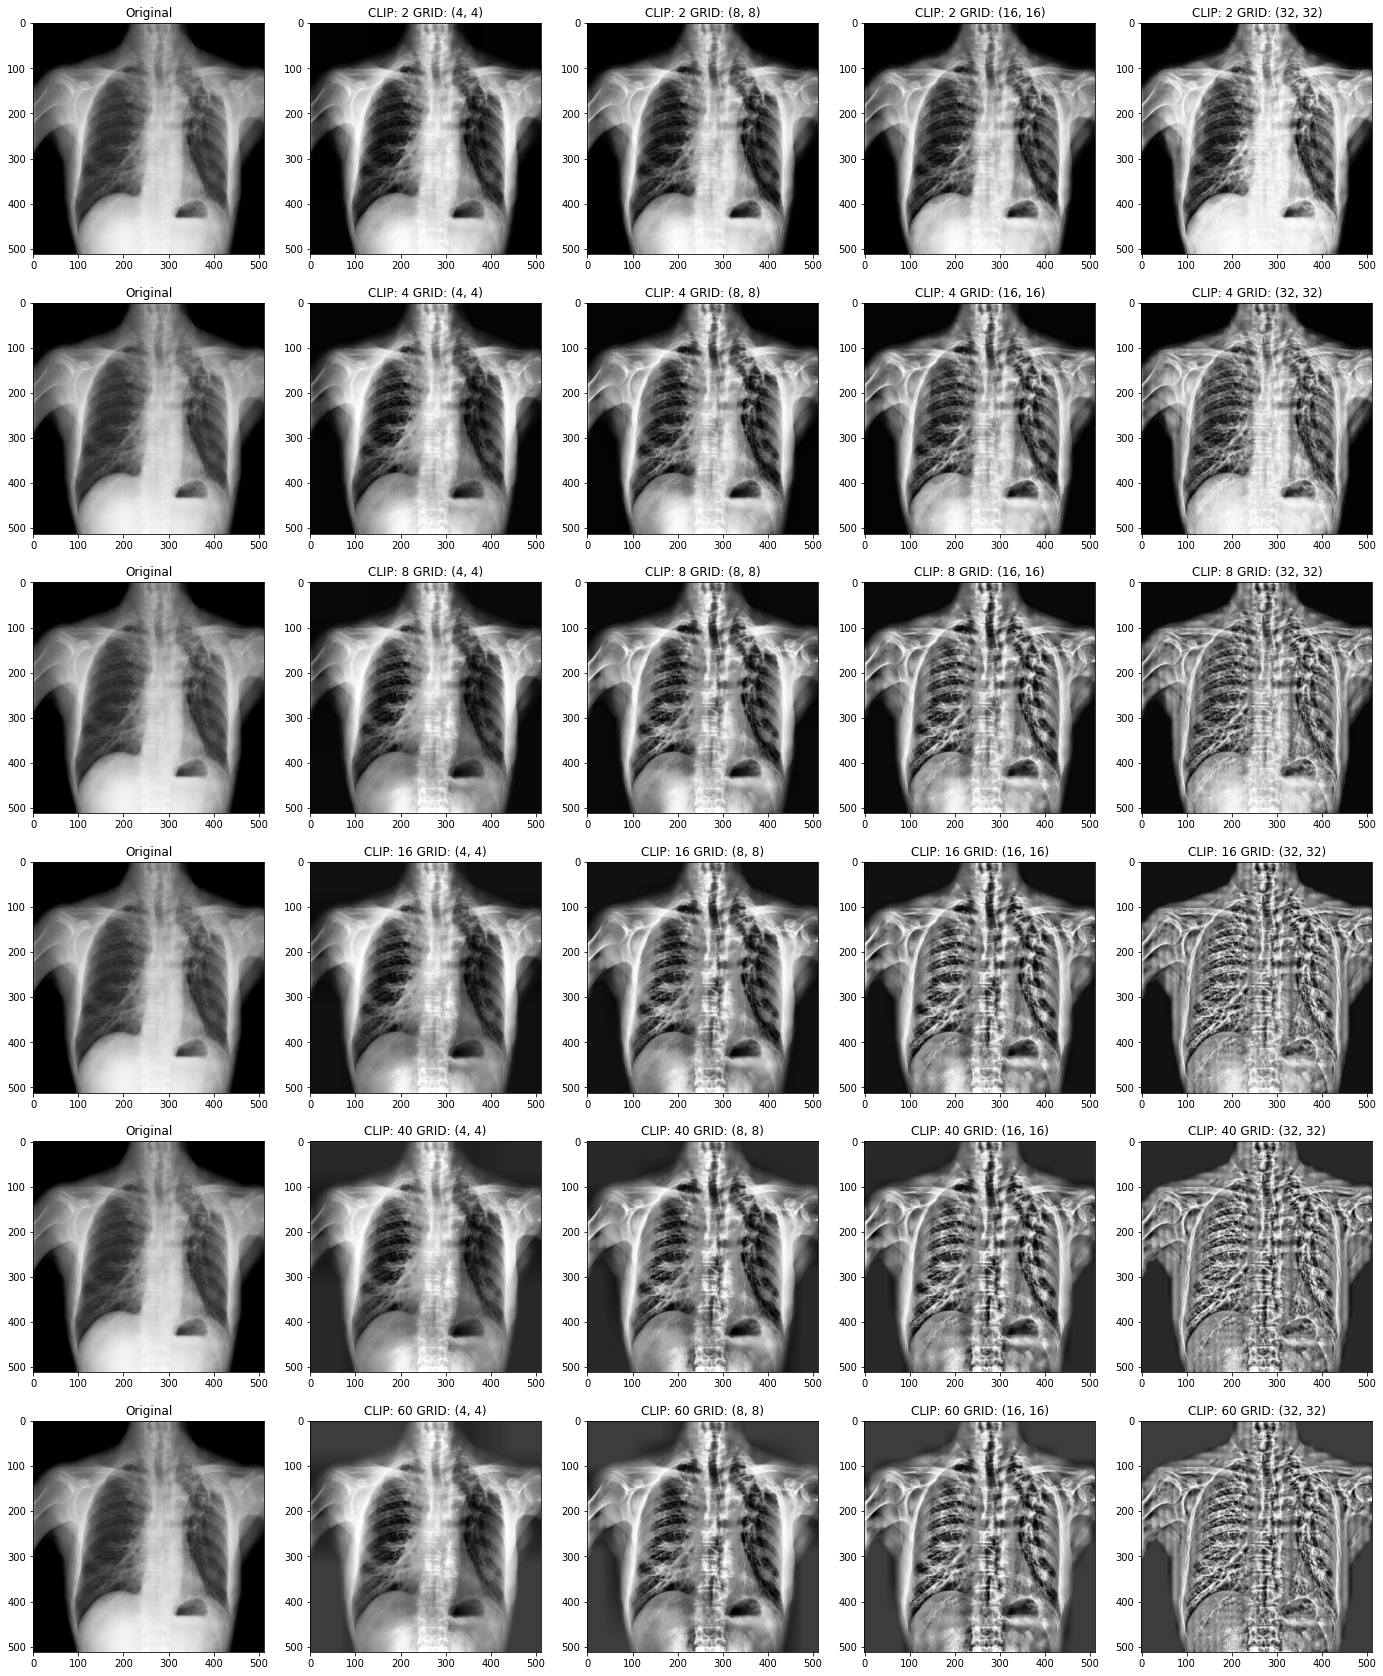

In [5]:
sick_train = glob(os.path.join(TBX_TRAIN_DIR,'tb','*.png'))
filename = sick_train[450]
fig, axs = plt.subplots(6, 5, figsize=(24, 30))

image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

grids = [(4,4),(8,8),(16,16),(32,32)]
clips = [2,4,8,16,40,60]

x=0

for clip in clips:
    y = 0
    axs[x, y].set_title('Original')
    axs[x, y].imshow(image,cmap='gray')
    y += 1
    for grid in grids:
        img_eq=cv2.equalizeHist(image)
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
        equalized = clahe.apply(img_eq)
        axs[x, y].set_title('CLIP: '+str(clip)+' GRID: '+str(grid))
        axs[x, y].imshow(equalized,cmap='gray')
        y +=1
    x += 1

plt.show()

#### Past Setup
- CLIP : 40
- GRID :(8,8)
- Val ACC: 98.06

**** 

- CLIP : 40,
- GRID : (4,4)
- Val ACC: 95.72

**** 

- CLIP : 8
- GRID : (8,8) 
- Model Overfitting at 57.8% accuracy. Stopped training

****
- CLIP : 4,
- GRID : (4,4)
- Val ACC: 97.50

****
- CLIP : 4,
- GRID : (16,16)
- Val ACC: 90.94


**** 
- CLIP : 4
- GRID: (8,8)
- Val Accuracy: 96.39
****
- CLIP: 2
- GRID: (16,16)
- Val Accuracy: 97.00

****
- CLIP: 2
- GRID: (4,4)
- VAL accuracy: 96.00

#### CLAHE TRAIN AND VALIDATION IMAGE CREATION

In [6]:
OUTPUT_SHAPE = (256,256)
CLIP = 4
GRID_SIZE = (4,4)
for class_dir in CLASSES:
    train_files = glob(os.path.join(TBX_TRAIN_DIR,class_dir,'*.png'))
    for src_file in tqdm(train_files):
        
        #create destination file path
        basename = os.path.basename(src_file)
        dst_file = os.path.join(CLAHE_TRAIN_DIR,class_dir,basename)
        
        #convert image to CLAHE enhanced image
        image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
        img_eq=cv2.equalizeHist(image)
        clahe = cv2.createCLAHE(clipLimit=CLIP, tileGridSize=GRID_SIZE)
        equalized = clahe.apply(img_eq)
        cv2.resize(equalized, OUTPUT_SHAPE)
        cv2.imwrite(dst_file, equalized)        

100%|██████████| 600/600 [00:07<00:00, 77.96it/s]


In [7]:
#Validation Image Enhancements

for class_dir in CLASSES:
    train_files = glob(os.path.join(TBX_VAL_DIR,class_dir,'*.png'))
    for src_file in tqdm(train_files):
        
        #create destination file path
        basename = os.path.basename(src_file)
        dst_file = os.path.join(CLAHE_VAL_DIR,class_dir,basename)
        
        #convert image to CLAHE enhanced image
        image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
        img_eq=cv2.equalizeHist(image)
        clahe = cv2.createCLAHE(clipLimit=CLIP, tileGridSize=GRID_SIZE)
        equalized = clahe.apply(img_eq)
        cv2.resize(equalized, OUTPUT_SHAPE)
        cv2.imwrite(dst_file, equalized)     

100%|██████████| 200/200 [00:02<00:00, 79.64it/s]


### HEF Image Enhancement

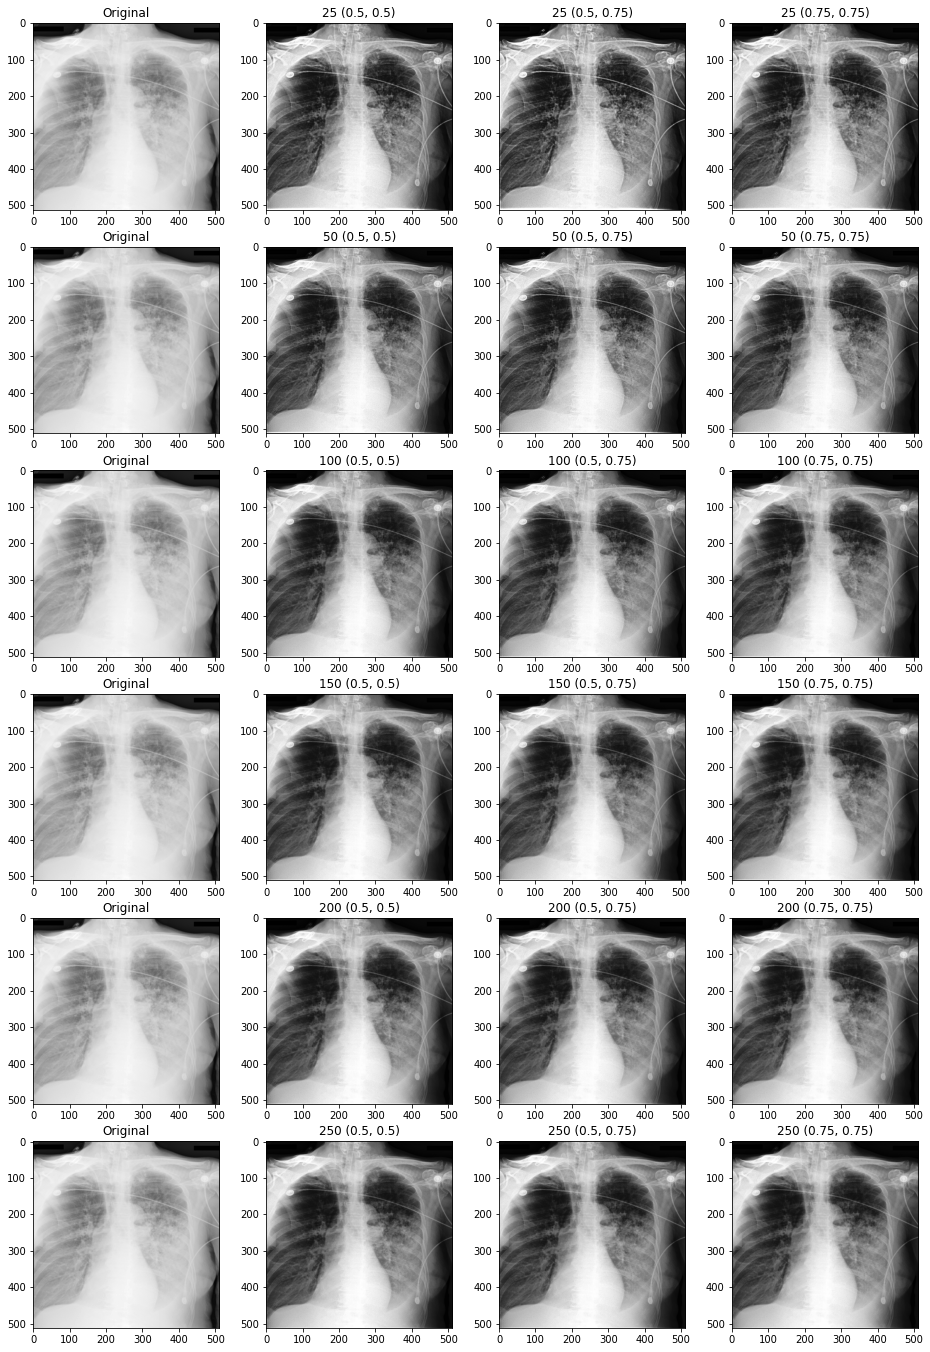

In [5]:
sick_train = glob(os.path.join(TBX_TRAIN_DIR,'sick','*.png'))
filename = sick_train[200]


grids = [(0.5,0.5),(0.5,0.75),(0.75,0.75)]
f_pows = [25,50,100,150,200,250]

fig, axs = plt.subplots(6,4, figsize=(16, 24))
x=0
for f_pow in f_pows:
    y = 0
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    axs[x, y].set_title('Original')
    axs[x, y].imshow(image,cmap='gray')
    y += 1
    for k1,k2 in grids:
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        h_image = HEF_Filter_Param(image,k1,k2,f_pow)
        title = str(f_pow)+' ('+str(k1)+', '+str(k2)+')'
        axs[x, y].set_title(title)
        axs[x, y].imshow(h_image,cmap='gray')
        y +=1
    x += 1

plt.show()

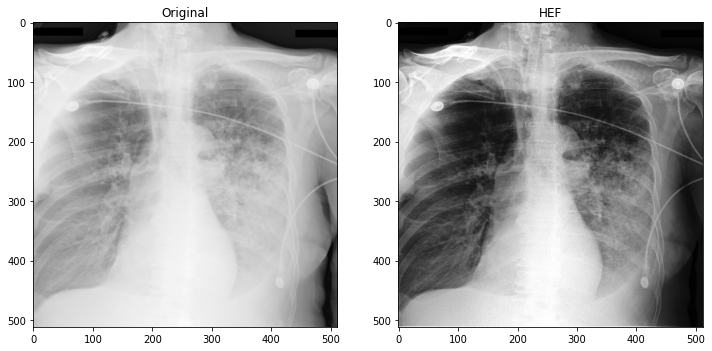

In [5]:
sick_train = glob(os.path.join(TBX_TRAIN_DIR,'sick','*.png'))
filename = sick_train[200]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
axs[0].set_title('Original')
axs[0].imshow(image,cmap='gray')

#(150,0.5,0.75)
hef_image = HEF_Filter_Param(image,0.5,0.75,150)

cv2.resize(hef_image, (256,256))
axs[1].set_title('HEF')
axs[1].imshow(hef_image,cmap='gray')
plt.show()

In [6]:
def hef_image_processing(src_file):
    #create destination file path
    paths = os.path.split(src_file)
    basename = paths[1]
    dir_path = paths[0].split('/')
    class_dir = dir_path[-1]
    dst_file = os.path.join(HEF_TRAIN_DIR,class_dir,basename)
    #convert original image to HEF image
    image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
    cv2.resize(image, OUTPUT_SHAPE)
    hef_image = HEF_Filter_Param(image,0.5,0.75,150)
    cv2.imwrite(dst_file, hef_image)

In [7]:
from multiprocessing import Pool
OUTPUT_SHAPE = (256,256)
for class_dir in tqdm(CLASSES):
    train_files = glob(os.path.join(TBX_TRAIN_DIR,class_dir,'*.png'))
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(hef_image_processing, train_files)

100%|██████████| 3/3 [20:45<00:00, 415.07s/it]


In [8]:
def hef_val_image_processing(src_file):
    #create destination file path
    paths = os.path.split(src_file)
    basename = paths[1]
    dir_path = paths[0].split('/')
    class_dir = dir_path[-1]
    dst_file = os.path.join(HEF_VAL_DIR,class_dir,basename)
    #convert original image to HEF image
    image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
    cv2.resize(image, OUTPUT_SHAPE)
    hef_image = HEF_Filter_Param(image,0.5,0.75,150)
    cv2.imwrite(dst_file, hef_image)

In [9]:
from multiprocessing import Pool
OUTPUT_SHAPE = (256,256)
for class_dir in tqdm(CLASSES):
    validation_files = glob(os.path.join(TBX_VAL_DIR,class_dir,'*.png'))
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(hef_val_image_processing, validation_files)

100%|██████████| 3/3 [05:44<00:00, 114.88s/it]


### Bilateral Filter Enhancements

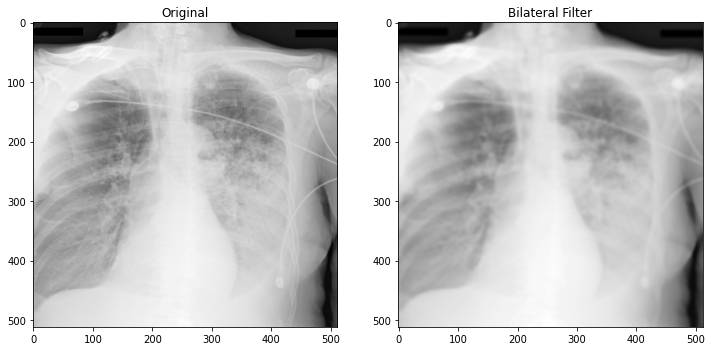

In [39]:
sick_train = glob(os.path.join(TBX_TRAIN_DIR,'sick','*.png'))
filename = sick_train[200]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
axs[0].set_title('Original')
axs[0].imshow(image,cmap='gray')

cv2.resize(image, (256,256))
bf_image = cv2.bilateralFilter(image, 9, 80, 80)
axs[1].set_title('Bilateral Filter')
axs[1].imshow(bf_image,cmap='gray')
plt.show()

In [40]:
def bf_train_image_processing(src_file):
    #create destination file path
    paths = os.path.split(src_file)
    basename = paths[1]
    dir_path = paths[0].split('/')
    class_dir = dir_path[-1]
    dst_file = os.path.join(BF_TRAIN_DIR,class_dir,basename)
    #convert original image to HEF image
    image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
    cv2.resize(image, OUTPUT_SHAPE)
    bf_image = cv2.bilateralFilter(image, 9, 80, 80)
    cv2.imwrite(dst_file, bf_image)

def bf_val_image_processing(src_file):
    #create destination file path
    paths = os.path.split(src_file)
    basename = paths[1]
    dir_path = paths[0].split('/')
    class_dir = dir_path[-1]
    dst_file = os.path.join(BF_VAL_DIR,class_dir,basename)
    #convert original image to HEF image
    image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
    cv2.resize(image, OUTPUT_SHAPE)
    bf_image = cv2.bilateralFilter(image, 9, 80, 80)
    cv2.imwrite(dst_file, bf_image)    

In [41]:
from multiprocessing import Pool
OUTPUT_SHAPE = (256,256)
for class_dir in tqdm(CLASSES):
    train_files = glob(os.path.join(TBX_TRAIN_DIR,class_dir,'*.png'))
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(bf_train_image_processing, train_files)

100%|██████████| 3/3 [00:19<00:00,  6.48s/it]


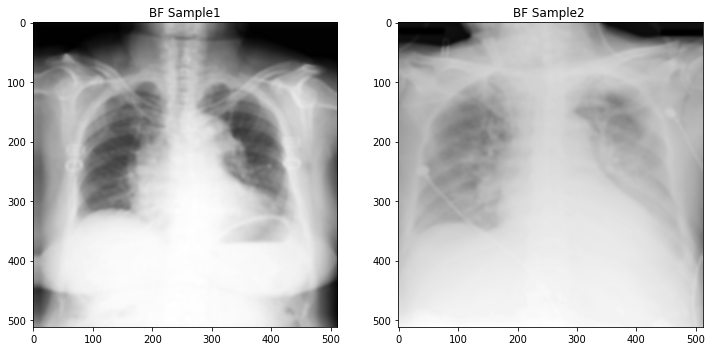

In [42]:
sick_train = glob(os.path.join(BF_TRAIN_DIR,'sick','*.png'))
filename = sick_train[200]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
axs[0].set_title('BF Sample1')
axs[0].imshow(image,cmap='gray')

image2 = cv2.imread(sick_train[400], cv2.IMREAD_GRAYSCALE)
axs[1].set_title('BF Sample2 ')
axs[1].imshow(image2,cmap='gray')
plt.show()

In [46]:
from multiprocessing import Pool
OUTPUT_SHAPE = (256,256)
for class_dir in tqdm(CLASSES):
    validation_files = glob(os.path.join(TBX_VAL_DIR,class_dir,'*.png'))
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(bf_val_image_processing, validation_files)

100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
